### Imports

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
from scipy.stats import f_oneway, kruskal
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from hyperopt import hp
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.experiment_utils import get_feature_extractor, extract_features, preprocessing_model
from utils.experiment_utils import get_images_from_supervised_set
from utils.visualization import plot_hist
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [2]:
datasets_dir = "c:/datasets/"
if os.path.isdir(datasets_dir) is not True:
    os.mkdir(datasets_dir)

In [3]:
ds_name = 'cifar100'
cifar100_ds, cifar100_ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(cifar100_ds_info)

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='c:/datasets/cifar100\\3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,

In [4]:
label_set = list(range(100))
train_images, train_labels = get_images_from_supervised_set(cifar100_ds[0], label_set, img_size=[32,32])
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (10000, 32, 32, 3)
labels shape = (10000,)


In [5]:
test_images, test_labels = get_images_from_supervised_set(cifar100_ds[1], label_set, img_size=[32,32])
print(f"images shape = {test_images.shape}")
print(f"labels shape = {test_labels.shape}")

images shape = (10000, 32, 32, 3)
labels shape = (10000,)


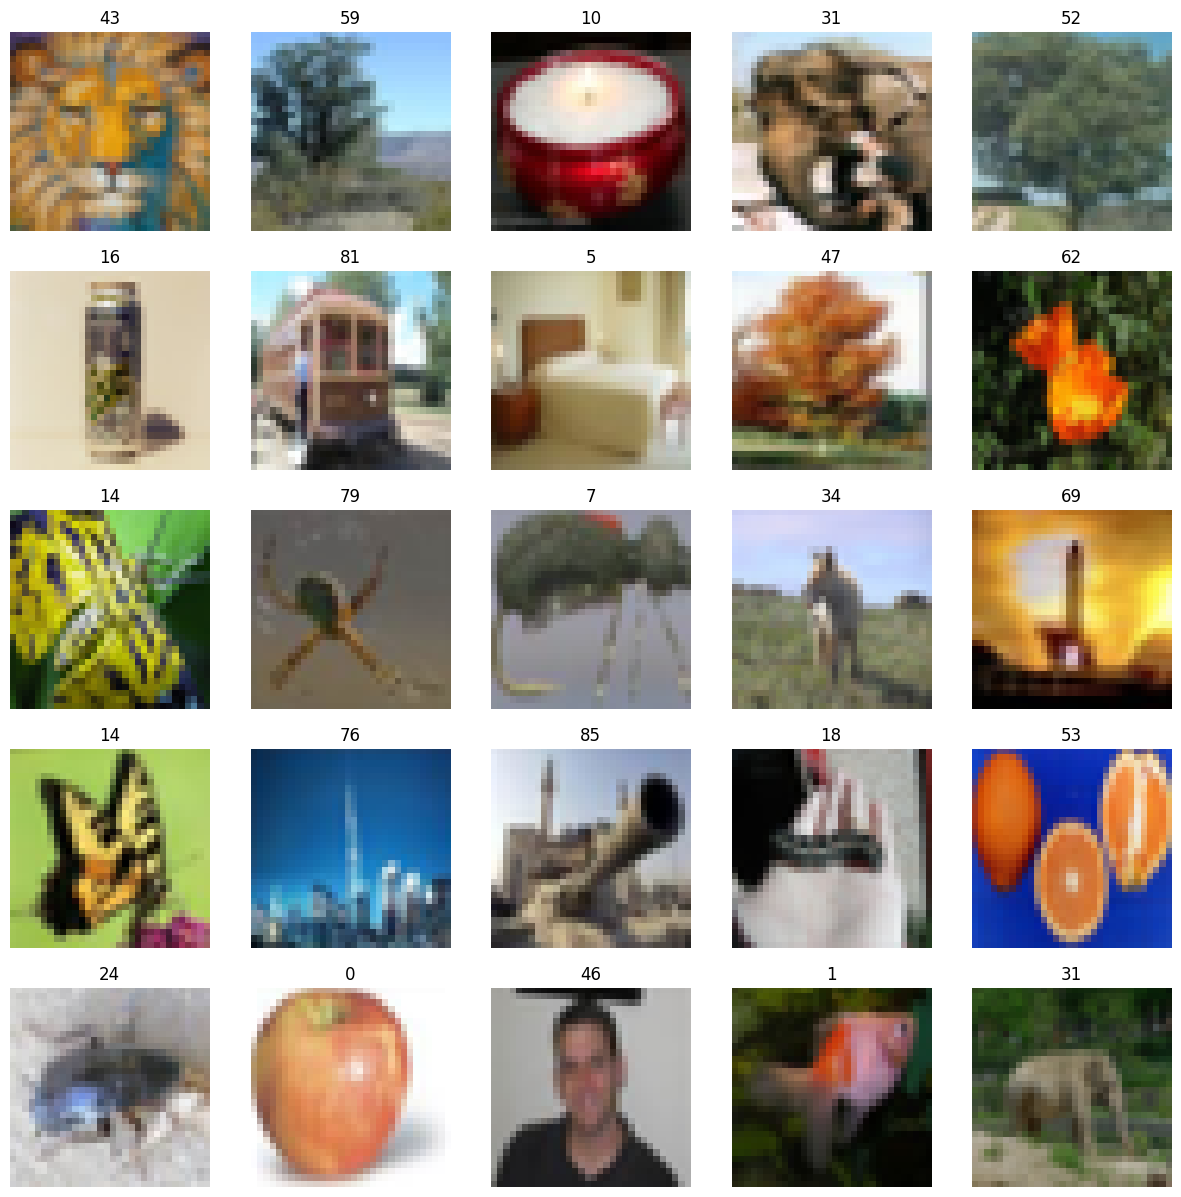

In [6]:
# plotting some examples from the data
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    ax.set_title(f"{test_labels[i]}")
    plt.axis("off")

### Define a feature extractor

In [7]:
model_name = 'resnet50_v2'
# resnet_v2 expects pixel values in [-1, 1], but the pixel values in images are in [0, 255].
# To rescale them, use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
# define an average pooling layer that will extract a single feature from each of the 2048 4x4 feature maps in the last layer of the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Create the base model from the pre-trained model
base_model = tf.keras.applications.ResNet50V2(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 18, 18, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

### Extract features

In [8]:
preprocess = preprocessing_model(input_shape=train_images.shape[1:],
                                            preprocess_layer=preprocess_input,
                                            noise_model=None)
feature_extractor = get_feature_extractor(base_model=base_model, input_shape=train_images.shape[1:], pooling_layer=global_average_layer)

In [9]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)
X_test  = extract_features(ds=test_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [10]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
else:
    y_train = train_labels
if tf.is_tensor(test_labels):
    y_test = test_labels.numpy()
else:
    y_test = test_labels
print(f"labels = {np.unique(y_train)}")


labels = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


### Explore feature selection and feature distribution

[0.41333333 0.37666667 0.4       ]
[2048.   64.  296.]


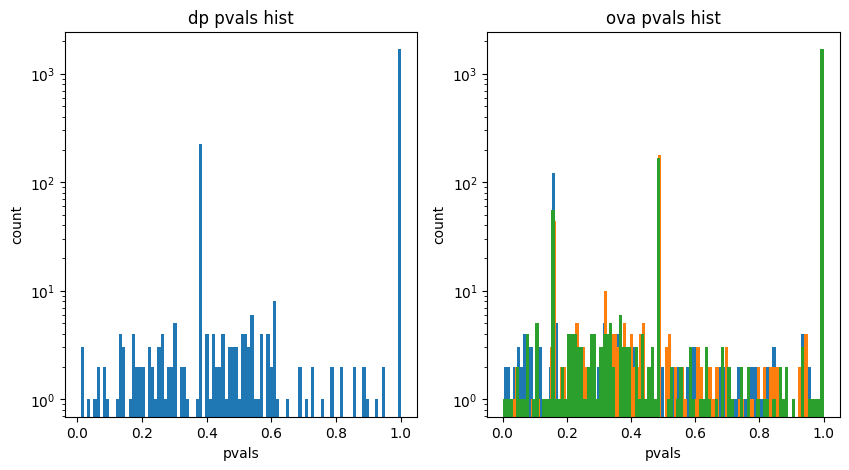

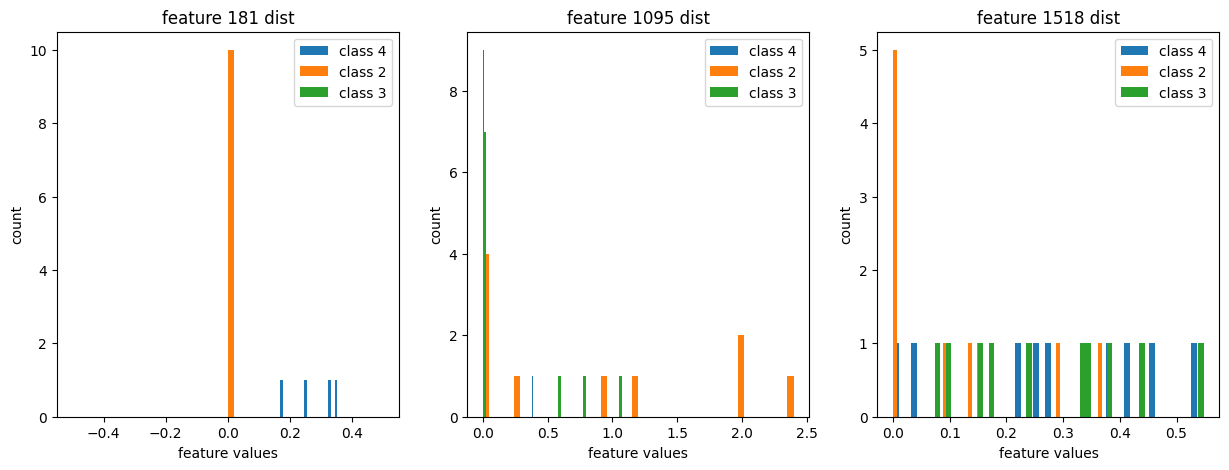

In [11]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.5
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=1000)
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
#s_fs_perm_dp = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova]
# sample a label set
num_classes = 3
train_size = 10
#label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
label_set = [4,2,3]
smpl_idx, test_idcs = [],[]
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(np.random.choice(cls_idcs,train_size,replace=False)))
    test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
fs_X_train = X_train[smpl_idx]
fs_y_train = y_train[smpl_idx]
exp_X_test = X_test[test_idcs]
exp_y_test = y_test[test_idcs]
# fit the feature selectors
dp_fs.fit(fs_X_train,fs_y_train)
ova_fs.fit(fs_X_train,fs_y_train)
#dp_perm_fs.fit(fs_X_train,fs_y_train)
accuracies, num_features = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=fs_X_train, y_train=fs_y_train, X_test=exp_X_test, y_test=exp_y_test)
print(accuracies)
print(num_features)

#print(np.flip(np.sort(dp_fs.f_stat)))
#print(np.flip(np.sort(dp_perm_fs.f_stat)))
# display the p-values
fig, ax = plt.subplots(1,2,figsize=(2*5,5))
plot_hist(ax[0],[dp_fs.pvals],bins=100,xlabel='pvals',title='dp pvals hist',log_scale=True)
plot_hist(ax[1],[ova_fs.pvals[k] for k in ova_fs.pvals.keys()],bins=100,xlabel='pvals',title='ova pvals hist',log_scale=True)
#plot_hist(ax[2],[dp_perm_fs.pvals],bins=100,xlabel='pvals',title='dp perm pvals hist',log_scale=True)
plt.show()
# find the features with the smallest p-values
num_pvals_to_display = 3
dp_pvals_argsort = np.argsort(dp_fs.pvals)
dp_informative_features = dp_pvals_argsort[:num_pvals_to_display]
fig, ax = plt.subplots(1,num_pvals_to_display,figsize=(num_pvals_to_display*5,5))
for i in range(len(dp_informative_features)):
    fi = dp_informative_features[i]
    info_feat_values = [fs_X_train[fs_y_train==l,fi] for l in label_set]
    plot_hist(ax[i],info_feat_values,bins=50,xlabel='feature values',title=f'feature {fi} dist',labels=[f"class {l}" for l in label_set])


### Experiment 1 - scanning train set size

In [12]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
label_set = np.random.choice(a=np.unique(y_train),size=5,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train = X_train[smpl_idx]
svm_y_train = y_train[smpl_idx]

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train)
best_params = hyper_opt.run()

100%|██████████| 150/150 [04:37<00:00,  1.85s/trial, best loss: -0.524]            


Measuring accuracy with 3 classes,  5 training examples per class
---------------------------------------------------------------




Measuring accuracy with 3 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 3 classes,  20 training examples per class
---------------------------------------------------------------




Measuring accuracy with 3 classes,  30 training examples per class
---------------------------------------------------------------






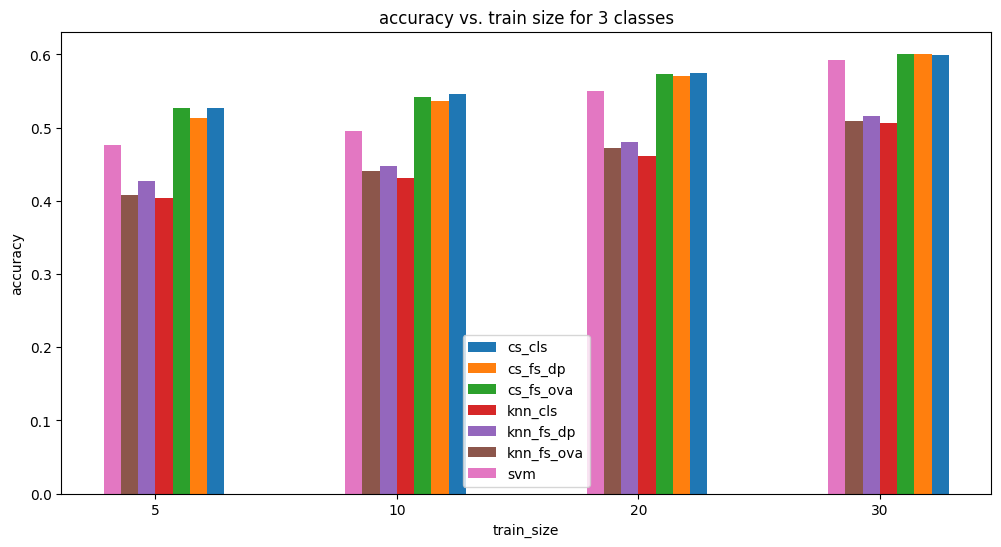

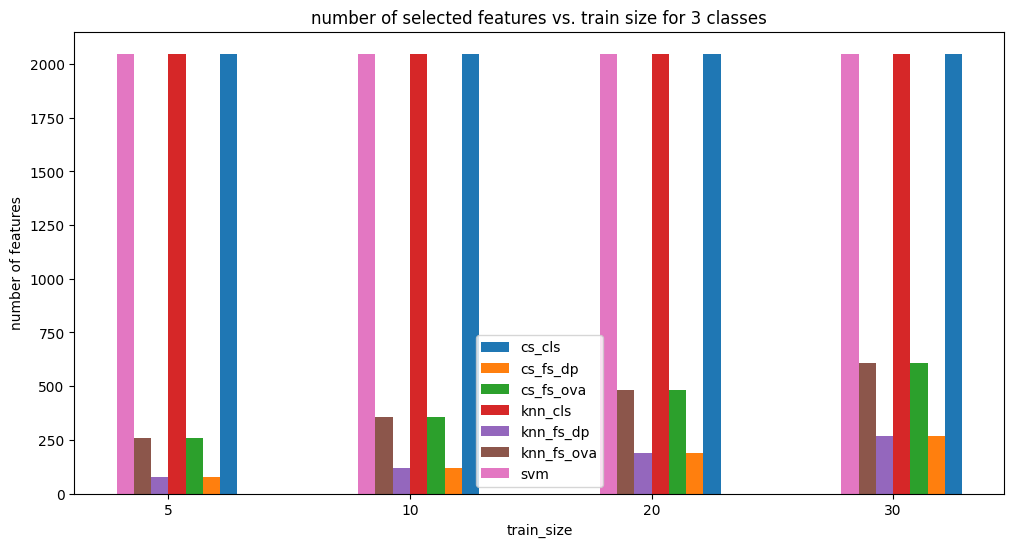

In [13]:
gamma = 0.5
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
train_sizes = [5,10,20,30]
num_classes = 3
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)


    print("\n\n\n")

# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

# plotting number of features for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')



### Experiment 2 - scan the number of classes

Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 20 classes,  10 training examples per class
---------------------------------------------------------------






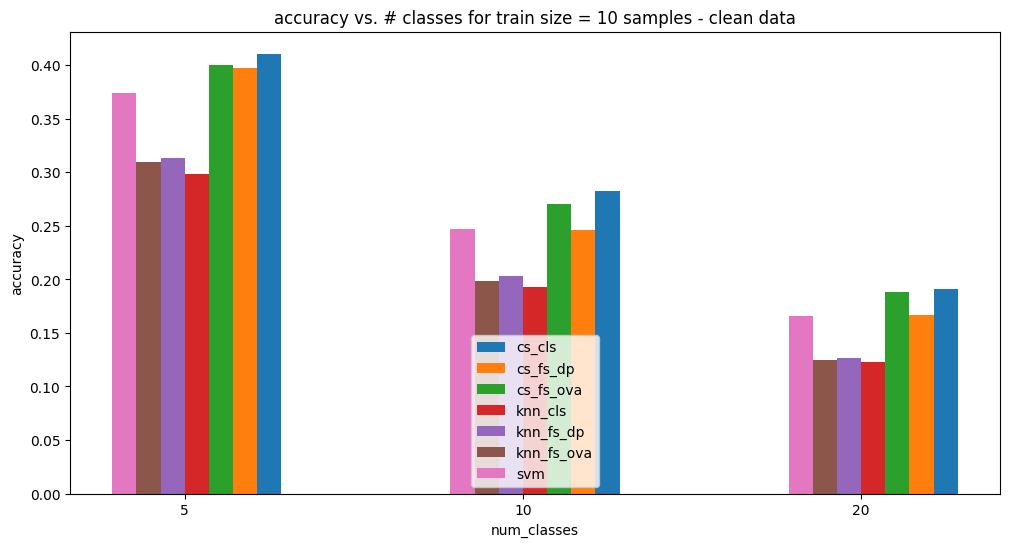

In [14]:
gamma = 0.5
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
train_size = 10
num_classes = [5,10,20]
accuracies = np.empty((len(classifiers),len(num_classes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(num_classes)):
    n = train_size
    print(f"Measuring accuracy with {num_classes[i]} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes[i],replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)


    print("\n\n\n")

# plotting results for the clean data
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=num_classes,
                xlabel='num_classes',
                ylabel='accuracy',
                title=f'accuracy vs. # classes for train size = {train_size} samples - clean data')



### Experiment 4 - classification on "hard to classify" labels


In [22]:
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
label_set = np.random.choice(a=np.unique(y_train),size=10,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train = X_train[smpl_idx]
svm_y_train = y_train[smpl_idx]
svm_X_test = X_test[smpl_idx]
svm_y_test = y_test[smpl_idx]
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train, iterations=70)
best_params = hyper_opt.run()
ref_model = SVC(**best_params)
ref_model.fit(X_train, y_train)
ref_model_pred = ref_model.predict(X_test)
ref_model_acc = accuracy_score(y_test, ref_model_pred)



100%|██████████| 70/70 [04:10<00:00,  3.58s/trial, best loss: -0.328]


In [26]:
class_report_dict = classification_report(y_test, ref_model_pred, output_dict=True)
threshold = 0.05
low_recall_classes = [c for c in list(np.unique(y_test)) if class_report_dict[str(c)]['recall'] < threshold]
print(f"there are {len(low_recall_classes)} hard to classify classes")
print(f"low_recall_classes = {low_recall_classes}")

there are 32 hard to classify classes
low_recall_classes = [3, 4, 11, 13, 18, 19, 23, 25, 26, 32, 35, 36, 38, 44, 45, 50, 55, 63, 64, 65, 66, 67, 72, 74, 77, 78, 79, 80, 84, 88, 90, 98]


Measuring accuracy with 5 classes,  10 training examples per class
---------------------------------------------------------------




Measuring accuracy with 5 classes,  20 training examples per class
---------------------------------------------------------------




Measuring accuracy with 5 classes,  30 training examples per class
---------------------------------------------------------------




Measuring accuracy with 5 classes,  50 training examples per class
---------------------------------------------------------------






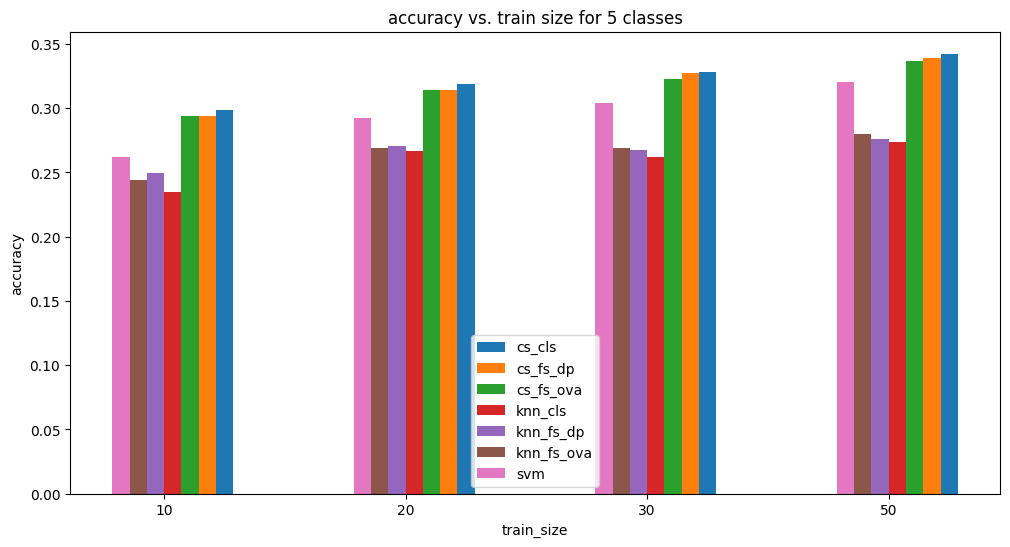

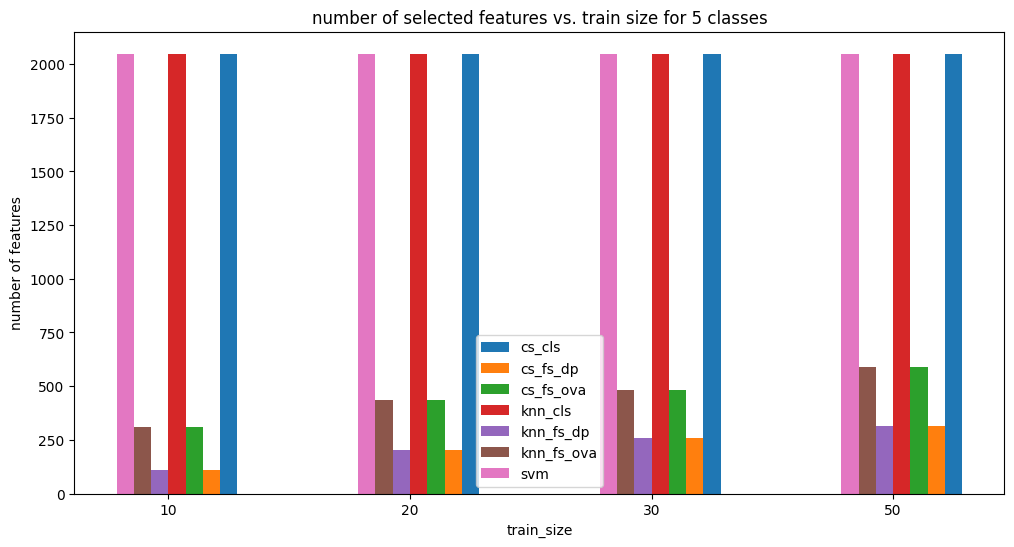

In [30]:
gamma = 0.5
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(cs_cls, dp_fs)
cs_fs_ova = ClassifierFeatureSelection(cs_cls, ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=5)
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
train_sizes = [10,20,30,50]
num_classes = 5
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set from the low recall classes
        label_set = np.random.choice(a=low_recall_classes,size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        test_idcs = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(np.random.choice(cls_idcs,n,replace=False)))
            test_idcs.extend(np.squeeze(np.argwhere(y_test == l)))
        smpl_X_train = X_train[smpl_idx]
        smpl_y_train = y_train[smpl_idx]
        exp_X_test = X_test[test_idcs]
        exp_y_test = y_test[test_idcs]
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers, X_train=smpl_X_train, y_train=smpl_y_train, X_test=exp_X_test, y_test=exp_y_test)


    print("\n\n\n")

# plotting results for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

# plotting number of features for the clean data
from utils.visualization import bar_plot_scores
bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm'],
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')

